In [1]:
import numpy as onp
import matplotlib.pyplot as plt

import jax 
from jax import config, jit, vmap, grad 
config.update("jax_enable_x64", True)
import jax.numpy as np
import jax.scipy as jsp
import jax.random as jr

import pyoifits as oifits
import glob

from drpangloss.models import *
from drpangloss.plotting import *
from drpangloss.grid_fit import *
from drpangloss.savefits import GetWavelength, save

import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig

import warnings; warnings.simplefilter('ignore')

cmap = plt.get_cmap('coolwarm')
cmap.set_bad(color='black')

fftshift = np.fft.fftshift

from scipy.ndimage import label, binary_dilation


/Users/benpope/opt/anaconda3/envs/pangloss/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ls ../data/amigo

amp_maps.npy   masks.npy      uv_coords.npy
holes.npy      pha_maps.npy   wl.npy


In [3]:
amp_maps = np.load('../data/amigo/amp_maps.npy',allow_pickle=True).item()
pha_maps = np.load('../data/amigo/pha_maps.npy',allow_pickle=True).item()
uv_coords = np.load('../data/amigo/uv_coords.npy',allow_pickle=True)
wl = np.load('../data/amigo/wl.npy',allow_pickle=True)
holes = np.load('../data/amigo/holes.npy',allow_pickle=True)


# eliminate reversed keys in splodges
splodges = np.load('../data/amigo/masks.npy',allow_pickle=True).item()
for key in list(splodges.keys()):
    if key[::-1] in splodges:
        splodges.pop(key)

dict_keys([(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)])


In [4]:
stars = [key for key in amp_maps.keys()]

In [5]:
all_splodges = np.array([splodges[key] for key in splodges.keys()])
weights = all_splodges/np.sum(all_splodges,axis=0)
dc = binary_dilation(np.max(weights,axis=0)<0.05,iterations=2)
all_splodges = all_splodges.at[:,dc].set(0.)

single_splodges = []
for j in range(all_splodges.shape[0]):
    label_objects, nb_labels = label(all_splodges[j,:,:])
    one_splodge = all_splodges[j,:].at[label_objects!=1].set(0.)
    single_splodges.append(one_splodge)
single_splodges = np.array(single_splodges)
npix_avg = np.median(np.sum(single_splodges>0.1,axis=(1,2)),axis=0) # some splodges are cut off - we want to have a sqrt(N) correction for their expected std


In [6]:
label_objects, nb_labels = label(all_splodges[0,:,:])
one_splodge = all_splodges[0,:].at[label_objects!=1].set(0.)

Text(0, 0.5, 'v (m)')

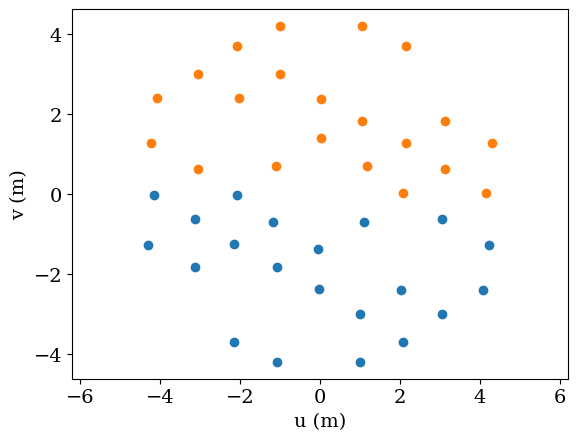

In [7]:
ugrid, vgrid = uv_coords
masks = np.copy(single_splodges)
masks = masks.at[masks<0.1].set(np.nan)
mask = np.any(np.isfinite(masks),axis=0)
mask = mask + mask[::-1,::-1]
nanmask = (mask*1.0).at[~mask].set(np.nan)

u = np.array([np.nanmean(single_splodges[j,:,:]*masks[j,:,:]*ugrid) for j in range(single_splodges.shape[0])])
v = np.array([np.nanmean(single_splodges[j,:,:]*masks[j,:,:]*vgrid) for j in range(single_splodges.shape[0])])

bl = np.sqrt(u**2+v**2)
plt.scatter(u,v)
plt.scatter(-u,-v)
plt.axis('equal')

plt.xlabel('u (m)')
plt.ylabel('v (m)')

In [8]:
stars

['HD-115842_F380M', 'HD-116084_F380M']

In [9]:
vis_HD_115842, phi_HD_115842 = amp_maps['HD-115842_F380M'].mean(axis=0), pha_maps['HD-115842_F380M'].mean(axis=0)
vis_err_HD_115842, phi_err_HD_115842 = amp_maps['HD-115842_F380M'].std(axis=0), pha_maps['HD-115842_F380M'].std(axis=0)

vis_HD_116084, phi_HD_116084 = amp_maps['HD-116084_F380M'].mean(axis=0), pha_maps['HD-116084_F380M'].mean(axis=0)
vis_err_HD_116084, phi_err_HD_116084 = amp_maps['HD-116084_F380M'].std(axis=0), pha_maps['HD-116084_F380M'].std(axis=0)

In [10]:
vis_samp_HD_115842 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*vis_HD_115842) for j in range(single_splodges.shape[0])])
vis_err_samp_HD_115842 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*vis_err_HD_115842)/np.sqrt(np.nansum(masks[j,:,:])) 
                                   for j in range(single_splodges.shape[0])])

vis_samp_HD_116084 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*vis_HD_116084) for j in range(single_splodges.shape[0])])
vis_err_samp_HD_116084 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*vis_err_HD_116084)/np.sqrt(np.nansum(masks[j,:,:])) 
                                   for j in range(single_splodges.shape[0])])

pha_samp_HD_115842 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*phi_HD_115842) for j in range(single_splodges.shape[0])])
pha_err_samp_HD_115842 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*phi_err_HD_115842)/np.sqrt(np.nansum(masks[j,:,:]))
                                      for j in range(single_splodges.shape[0])])

pha_samp_HD_116084 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*phi_HD_116084) for j in range(single_splodges.shape[0])])
pha_err_samp_HD_116084 = np.array([np.nanmedian(single_splodges[j,:,:]*masks[j,:,:]*phi_err_HD_116084)/np.sqrt(np.nansum(masks[j,:,:]))
                                        for j in range(single_splodges.shape[0])])

# the errorbars here are way too small - this is for standard error of the mean

# convert phases to deg, visibilities to %
pha_samp_HD_115842 = np.degrees(pha_samp_HD_115842)
pha_err_samp_HD_115842 = np.degrees(pha_err_samp_HD_115842)
vis_samp_HD_115842 = (vis_samp_HD_115842-1)*100
vis_err_samp_HD_115842 = (vis_err_samp_HD_115842)*100

pha_samp_HD_116084 = np.degrees(pha_samp_HD_116084)
pha_err_samp_HD_116084 = np.degrees(pha_err_samp_HD_116084)
vis_samp_HD_116084 = (vis_samp_HD_116084-1)*100
vis_err_samp_HD_116084 = (vis_err_samp_HD_116084)*100

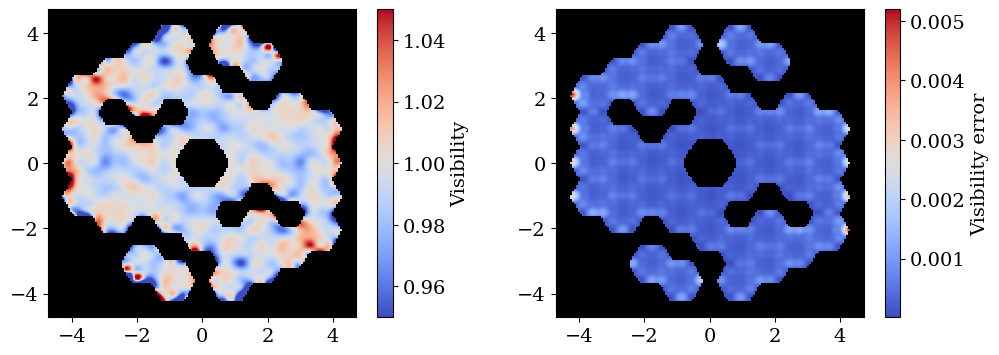

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

im = ax1.imshow(nanmask*vis_HD_115842, cmap=cmap, origin='lower', 
           extent=[-np.max(bl),np.max(bl),-np.max(bl),np.max(bl)],
           vmin=0.95, vmax=1.05)

# colorbar
cbar = plt.colorbar(im, label='Visibility')

im2 = ax2.imshow(nanmask*vis_err_HD_115842, cmap=cmap, origin='lower',
              extent=[-np.max(bl),np.max(bl),-np.max(bl),np.max(bl)])

cbar = plt.colorbar(im2, label='Visibility error')

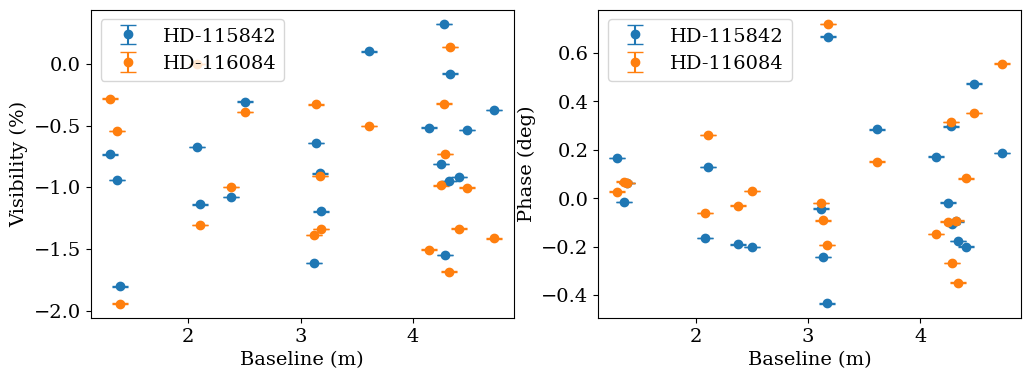

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.errorbar(bl, vis_samp_HD_115842, yerr=vis_err_samp_HD_115842, fmt='o', capsize=6, label='HD-115842')
ax1.errorbar(bl, vis_samp_HD_116084, yerr=vis_err_samp_HD_116084, fmt='o',capsize=6, label='HD-116084')
ax1.set_xlabel('Baseline (m)')
ax1.set_ylabel('Visibility (%)')
ax1.legend()

ax2.errorbar(bl, pha_samp_HD_115842, yerr=pha_err_samp_HD_115842, fmt='o', capsize=6, label='HD-115842')
ax2.errorbar(bl, pha_samp_HD_116084, yerr=pha_err_samp_HD_116084, fmt='o', capsize=6, label='HD-116084')
ax2.set_xlabel('Baseline (m)')
ax2.set_ylabel('Phase (deg)')
ax2.legend()


Text(0.5, 1.0, 'Scatter: 0.17 deg')

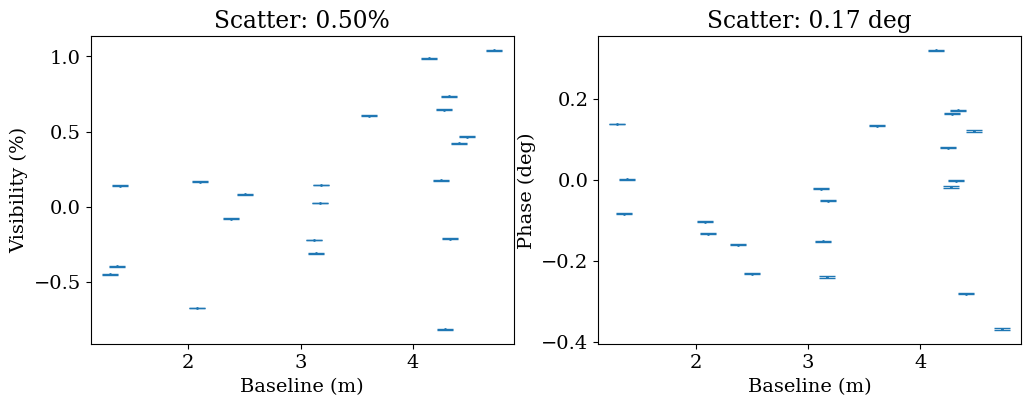

In [13]:
# calibrated

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.errorbar(bl, vis_samp_HD_115842-vis_samp_HD_116084, yerr=np.sqrt(vis_err_samp_HD_115842**2+vis_err_samp_HD_116084**2), 
            fmt='o',capsize=6,markersize=1, label='Calibrated')

ax1.set_xlabel('Baseline (m)')
ax1.set_ylabel('Visibility (%)')
ax1.set_title(f'Scatter: {np.nanstd(vis_samp_HD_115842-vis_samp_HD_116084):.2f}%')

ax2.errorbar(bl, pha_samp_HD_115842-pha_samp_HD_116084, yerr=np.sqrt(pha_err_samp_HD_115842**2+pha_err_samp_HD_116084**2),
            fmt='o',capsize=6,markersize=1, label='Calibrated')
ax2.set_xlabel('Baseline (m)')
ax2.set_ylabel('Phase (deg)')

ax2.set_title(f'Scatter: {np.nanstd(pha_samp_HD_115842-pha_samp_HD_116084):.2f} deg')